In [ ]:
# default_exp models

In [ ]:
#all_slow

# Models
> Classes and helper functions for all Deep Learning models used in this library.

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [ ]:
#export
from lemonpie.basics import * 
from lemonpie.preprocessing.vocab import * #for loading vocabs
from lemonpie.preprocessing.transform import * #for loading ptlist thru EHRData
from lemonpie.data import * #for EHRData
from lemonpie.learn import * #for fit/predict stuff
from lemonpie.metrics import * #for auroc_score
from fastai.imports import *

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
DEVICE

device(type='cuda')

## Dropouts 

This is the `RNNDropout` from fast.ai renamed as `InputDropout`
- [docs](https://docs.fast.ai/text.models.awdlstm.html) 
- [source](https://github.com/fastai/fastai/blob/master/fastai/text/models/awdlstm.py)

In [ ]:
#export
def dropout_mask(x, sz, p):
    '''Dropout mask as described in fast.ai'''
    return x.new(*sz).bernoulli_(1-p).div_(1-p)

class InputDropout(nn.Module):
    '''InputDropout - same as RNNDropout described in fast.ai'''
    def __init__(self, p=0.5):
        super().__init__()
        self.p=p

    def forward(self, x):
        if not self.training or self.p == 0.: return x
        m = dropout_mask(x.data, (x.size(0), 1, x.size(2)), self.p)
        return x * m

In [ ]:
x = torch.randn(2,3,5) #bs=2, seq_len(bptt)=3, x(emb width)=5
mask = dropout_mask(x, (2,1,5), 0.75)
x, mask, x*mask

(tensor([[[ 0.6743,  0.7882, -0.6500, -0.1299,  0.8923],
          [ 1.3448, -0.6973, -0.1652, -1.0681, -0.0916],
          [-0.4536, -0.0102,  0.0171,  0.9264,  0.2458]],
 
         [[ 0.5321,  0.0695,  0.1672, -0.8800, -0.9211],
          [ 0.6365,  0.4383,  0.0135,  1.4781,  0.2736],
          [ 0.4159, -0.4864, -0.1627, -0.0067,  0.0374]]]),
 tensor([[[4., 0., 0., 0., 0.]],
 
         [[0., 4., 0., 4., 0.]]]),
 tensor([[[ 2.6971,  0.0000, -0.0000, -0.0000,  0.0000],
          [ 5.3791, -0.0000, -0.0000, -0.0000, -0.0000],
          [-1.8146, -0.0000,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0000,  0.2780,  0.0000, -3.5199, -0.0000],
          [ 0.0000,  1.7530,  0.0000,  5.9124,  0.0000],
          [ 0.0000, -1.9455, -0.0000, -0.0268,  0.0000]]]))

In [ ]:
mask.std(), (x*mask).std(), x.std()

(tensor(1.9322), tensor(1.7739), tensor(0.6377))

In [ ]:
mask.mean(), (x*mask).mean(), x.mean()

(tensor(1.2000), tensor(0.2904), tensor(0.1076))

In [ ]:
dp = InputDropout(0.3)
tst_input = torch.randn(2,3,5)
tst_input, dp(tst_input)

(tensor([[[-0.4286, -0.5511,  0.1740,  1.3840,  0.4462],
          [ 0.4619,  0.4152, -0.0237, -0.1639,  1.1739],
          [ 0.1633,  1.5572,  0.0621, -0.2651, -1.1233]],
 
         [[-0.4247,  1.3134, -1.0984,  0.2525,  0.7761],
          [-0.8449, -0.2277,  0.1485,  1.2175,  1.2422],
          [ 0.7449, -0.9292,  0.1551, -0.4800,  1.0697]]]),
 tensor([[[-0.6124, -0.7873,  0.0000,  1.9771,  0.0000],
          [ 0.6599,  0.5932, -0.0000, -0.2341,  0.0000],
          [ 0.2333,  2.2246,  0.0000, -0.3788, -0.0000]],
 
         [[-0.6067,  1.8763, -0.0000,  0.0000,  1.1087],
          [-1.2070, -0.3254,  0.0000,  0.0000,  1.7745],
          [ 1.0641, -1.3274,  0.0000, -0.0000,  1.5281]]]))

In [ ]:
tst_input.std(), dp(tst_input).std()

(tensor(0.7732), tensor(0.6975))

## Linear Layers

In [ ]:
#export
def linear_layer(in_features, out_features, bn=False, dropout_p=0.0):
    '''Create a single linear layer'''
    layer = [nn.Linear(in_features, out_features)]
    if bn: layer.append(nn.BatchNorm1d(out_features))
    layer.append(nn.ReLU(inplace=True))
    layer.append(nn.Dropout(dropout_p))
    return layer

def create_linear_layers(in_features_start, num_layers, bn=False, dropout_p=0.0):
    '''Create linear layers'''
    layers = []
    
    for l in range(num_layers):    
        in_features = in_features_start if l==0 else out_features
        out_features = in_features * 2
        layers.extend(linear_layer(in_features, out_features, bn, dropout_p))

    return out_features, nn.Sequential(*layers)

In [ ]:
out, m = create_linear_layers(100, 4, bn=True)

In [ ]:
m, out

(Sequential(
   (0): Linear(in_features=100, out_features=200, bias=True)
   (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace=True)
   (3): Dropout(p=0.0, inplace=False)
   (4): Linear(in_features=200, out_features=400, bias=True)
   (5): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace=True)
   (7): Dropout(p=0.0, inplace=False)
   (8): Linear(in_features=400, out_features=800, bias=True)
   (9): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace=True)
   (11): Dropout(p=0.0, inplace=False)
   (12): Linear(in_features=800, out_features=1600, bias=True)
   (13): BatchNorm1d(1600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (14): ReLU(inplace=True)
   (15): Dropout(p=0.0, inplace=False)
 ),
 1600)

## `EHR_LSTM`

Based on this paper<br>
[Rajkomar, A., Oren, E., Chen, K. et al. Scalable and accurate deep learning with electronic health records. npj Digital Med 1, 18 (2018)](https://doi.org/10.1038/s41746-018-0029-1)

In [ ]:
#export
def init_lstm(m, initrange, zero_bn=False):
    '''Initialize LSTM'''
    if isinstance(m, (nn.Embedding, nn.EmbeddingBag)): m.weight.data.uniform_(-initrange, initrange)
    if isinstance(m, (nn.LSTM, nn.Linear)): 
        for name, param in m.named_parameters():
                if 'bias' in name:     
                    nn.init.constant_(param, 0.0)
                elif 'weight' in name: 
                    nn.init.kaiming_normal_(param)
    if isinstance(m, (nn.BatchNorm1d)): nn.init.constant_(m.weight, 0. if zero_bn else 1.)
    for l in m.children(): init_lstm(l, initrange, zero_bn)

In [ ]:
#export
from fastai.layers import BatchNorm1dFlat
class EHR_LSTM(nn.Module):
    '''Based on LSTM described in this paper - https://arxiv.org/abs/1801.07860''' 
                         
    def __init__(self, demograph_dims, rec_dims, demograph_wd, rec_wd, lstm_layers=4, linear_layers=4, 
                 initrange=0.3, bn=False, input_drp=0.3, lstm_drp=0.3, linear_drp=0.3, zero_bn=False):
        
        super().__init__()
        
        self.embs  = nn.ModuleList([nn.Embedding(*dim) for dim in demograph_dims])
        self.embgs = nn.ModuleList([nn.EmbeddingBag(*dim) for dim in rec_dims])
        
        self.rec_wd        = rec_wd      
        self.demograph_wd  = demograph_wd
        self.nh            = rec_wd    
        self.lstm_layers   = lstm_layers
        self.bn            = bn
        lin_features_start = (demograph_wd + 1) + rec_wd #adding 1 for age_now

        
        self.input_dp = InputDropout(input_drp)
        self.lstm     = nn.LSTM(input_size=self.nh, hidden_size=self.nh, num_layers=lstm_layers, batch_first=True, dropout=lstm_drp)
        if bn: self.lstm_bn = BatchNorm1dFlat(self.nh) #fastai - `nn.BatchNorm1d`, but first flattens leading dimensions
        out, self.lin = create_linear_layers(lin_features_start, linear_layers, bn, linear_drp)
        self.lin_o    = nn.Linear(out, 4)     

        init_lstm(self, initrange, zero_bn)

            
    def get_embs(self, ptbatch_recs, ptbatch_demogs, x):
        for p in range(len(x)): #for the batch of pts
            ptbatch_recs[p] = torch.cat((self.embgs[0](x[p].obs_nums,x[p].obs_offsts), 
                                         self.embgs[1](x[p].alg_nums,x[p].alg_offsts),
                                         self.embgs[2](x[p].crpl_nums,x[p].crpl_offsts),
                                         self.embgs[3](x[p].med_nums,x[p].med_offsts),
                                         self.embgs[4](x[p].img_nums,x[p].img_offsts),
                                         self.embgs[5](x[p].proc_nums,x[p].proc_offsts),
                                         self.embgs[6](x[p].cnd_nums,x[p].cnd_offsts),
                                         self.embgs[7](x[p].imm_nums,x[p].imm_offsts)),
                                        dim=1) #for the entire age span, example all 20 yrs
            ptbatch_demogs[p] = torch.cat((self.embs[0](x[p].demographics[0]), 
                                           self.embs[1](x[p].demographics[1]),
                                           self.embs[2](x[p].demographics[2]),
                                           self.embs[3](x[p].demographics[3]),
                                           self.embs[4](x[p].demographics[4]),
                                           self.embs[5](x[p].demographics[5]),
                                           self.embs[6](x[p].demographics[6]),
                                           self.embs[7](x[p].demographics[7]),
                                           self.embs[8](x[p].demographics[8]),
                                           self.embs[9](x[p].demographics[9]),
                                           self.embs[10](x[p].demographics[10]),
                                           x[p].age_now)) 

        return ptbatch_recs, ptbatch_demogs
    
    def forward(self, x):
        
        bs   = len(x)
        bptt = len(x[0].obs_offsts)
        h    = torch.zeros(self.lstm_layers,bs,self.nh, device=DEVICE)
        
        ptbatch_recs   = torch.empty(bs,bptt,self.rec_wd, device=DEVICE)
        ptbatch_demogs = torch.empty(bs,self.demograph_wd+1, device=DEVICE)
        ptbatch_recs, ptbatch_demogs = self.get_embs(ptbatch_recs, ptbatch_demogs, x)
        
        ptbatch_recs = self.input_dp(ptbatch_recs)                                     #apply input dropout
        
        res,_ = self.lstm(ptbatch_recs, (h,h))
        res   = self.lstm_bn(res[:,-1]) if self.bn else res[:,-1]                      #lstm output
        res   = self.lin(torch.cat((res, ptbatch_demogs), dim=1))                      #concat demographics + send thru linear lyrs
        out   = self.lin_o(res)

        return out

**Load Data**

In [ ]:
SYNTHEA_DATAGEN_DATES['1K']

'03-15-2021'

In [ ]:
preprocess_ehr_dataset(PATH_1K, SYNTHEA_DATAGEN_DATES['1K'], age_start=240, age_stop=360, age_in_months=True)

Since data is pre-cleaned, skipping Cleaning, Splitting and Vocab-creation
------------------- Creating patient lists -------------------
702 total patients completed, saved patient list to /home/vinod/.lemonpie/datasets/synthea/1K/processed/months_240_to_360/train
234 total patients completed, saved patient list to /home/vinod/.lemonpie/datasets/synthea/1K/processed/months_240_to_360/valid
235 total patients completed, saved patient list to /home/vinod/.lemonpie/datasets/synthea/1K/processed/months_240_to_360/test


In [ ]:
ehr_1K_data = EHRData(PATH_1K, LABELS, age_start=240, age_stop=360, age_in_months=True)

In [ ]:
demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd = get_all_emb_dims(EhrVocabList.load(PATH_1K))

In [ ]:
train_dl, valid_dl, train_pos_wts, valid_pos_wts = ehr_1K_data.get_data()

#### Inspect Data

In [ ]:
ehr_1K_data.splits.train

PatientList (702 items)
base path:/home/vinod/.lemonpie/datasets/synthea/1K; split:train; age span:120 months
age_start:240; age_stop:360; age_type:months
ptid:0ace3e15-8aa4-41c5-8b90-2408285ebcfe, birthdate:1986-04-02, diabetes:False, device:cpu
ptid:af1495be-5077-4087-98b1-9ff624c7582c, birthdate:2008-07-17, diabetes:False, device:cpu
ptid:f23e12d9-2ec6-4006-b041-ea78d374e9c9, birthdate:2014-09-06, diabetes:False, device:cpu
ptid:1968aa31-5fce-461a-9486-6e385a7b75e7, birthdate:1986-04-11, diabetes:False, device:cpu
ptid:1211c8ff-ab73-49f3-b2ab-87b7a03f6167, birthdate:1972-03-24, diabetes:False, device:cpu
ptid:27a8b7b6-007d-4036-82a7-80a9ab670dcb, birthdate:2005-04-13, diabetes:False, device:cpu
ptid:532696f2-0b76-4eb0-9aea-a74e2fb1bed2, birthdate:1967-05-18, diabetes:False, device:cpu
ptid:8641e13a-c832-4d97-811a-b735d0abb45e, birthdate:1982-10-06, diabetes:False, device:cpu
ptid:7f874045-4062-405d-8c23-abb12d0af23e, birthdate:1972-05-20, diabetes:False, device:cpu
ptid:0b6a83ae-fcb

Inspect a single patient

In [ ]:
pt = ehr_1K_data.splits.train[3] 

In [ ]:
pt.obs_nums, pt.obs_offsts

(tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0, 108, 112, 121,   0,   5,   8,  14,  18,
          28,  32,  38,  44, 467,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         108, 112, 121,   5,   8,  14,  19,  28,  32,  40,  44, 467,   0,   5,
           8,  14,  19,  28,  33,  39,  45, 467,   0,   0,   0,   0,   0,   0,
           0,   0,   5,   8,  14,  19,  28,  33,  38,  44, 467, 108, 112, 121,
           0,   0,   5,   9,  14,  19,  29,  33,  40,  45,  54,  60,  65,  71,
          73,  79,  85,  90,  93,  98, 103, 467,   0,   0,   0,   0,   0,   0,
           0,   0, 108, 112, 121,   0,   0,   5,   8,  15,  19,  28,  33,  38,
          45, 467,   0,   0,  49,   0,   0,   0,   0,   0, 108, 112, 121,   0,
           0,   5,   7,  15,  19,  28,  33,  38,  42

In [ ]:
len(pt.img_nums), len(pt.img_offsts)

(120, 120)

In [ ]:
len(pt.obs_nums), len(pt.obs_offsts)

(208, 120)

In [ ]:
pt

ptid:1968aa31-5fce-461a-9486-6e385a7b75e7, birthdate:1986-04-11, diabetes:False, device:cpu

In [ ]:
len(train_dl), len(valid_dl)

(11, 2)

In [ ]:
train_pos_wts, valid_pos_wts

(tensor([15., 22., 58., 17.]), tensor([16., 32., 32., 20.]))

In [ ]:
demograph_dims, demograph_dims_wd

([(33, 8),
  (14, 7),
  (124, 11),
  (5, 5),
  (7, 6),
  (4, 5),
  (4, 5),
  (243, 14),
  (208, 13),
  (3, 5),
  (181, 13)],
 92)

In [ ]:
rec_dims, rec_dims_wd

([(536, 17),
  (26, 8),
  (50, 9),
  (226, 13),
  (11, 6),
  (137, 12),
  (184, 13),
  (20, 7)],
 85)

**Inspect Model**

In [ ]:
model = EHR_LSTM(demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd)

In [ ]:
model

EHR_LSTM(
  (embs): ModuleList(
    (0): Embedding(33, 8)
    (1): Embedding(14, 7)
    (2): Embedding(124, 11)
    (3): Embedding(5, 5)
    (4): Embedding(7, 6)
    (5): Embedding(4, 5)
    (6): Embedding(4, 5)
    (7): Embedding(243, 14)
    (8): Embedding(208, 13)
    (9): Embedding(3, 5)
    (10): Embedding(181, 13)
  )
  (embgs): ModuleList(
    (0): EmbeddingBag(536, 17, mode=mean)
    (1): EmbeddingBag(26, 8, mode=mean)
    (2): EmbeddingBag(50, 9, mode=mean)
    (3): EmbeddingBag(226, 13, mode=mean)
    (4): EmbeddingBag(11, 6, mode=mean)
    (5): EmbeddingBag(137, 12, mode=mean)
    (6): EmbeddingBag(184, 13, mode=mean)
    (7): EmbeddingBag(20, 7, mode=mean)
  )
  (input_dp): InputDropout()
  (lstm): LSTM(85, 85, num_layers=4, batch_first=True, dropout=0.3)
  (lin): Sequential(
    (0): Linear(in_features=178, out_features=356, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=356, out_features=712, bias=True)
    (4): R

In [ ]:
# for name, param in model.named_parameters():
#     print(f'{name}::\n{param}')

### Test `fit()`

In [ ]:
train_loss_fn, valid_loss_fn = get_loss_fn(train_pos_wts), get_loss_fn(valid_pos_wts)

In [ ]:
model = EHR_LSTM(demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd).to(DEVICE) #.cuda() to be called before optim

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters())

In [ ]:
h = RunHistory(LABELS)

In [ ]:
%time h = fit(2, h, model, train_loss_fn, valid_loss_fn, optimizer, auroc_score, \
              train_dl, valid_dl, to_chkpt_path=MODEL_STORE, from_chkpt_path=None, verbosity=1)

epoch |     train loss |     train aurocs                  valid loss |     valid aurocs    
----------------------------------------------------------------------------------------------------
    0 |          6.367 | [0.607 0.596 0.712 0.599]              1.035 | [0.683 0.759 0.973 0.847]
    1 |          1.091 | [0.651 0.874 0.893 0.723]              1.079 | [0.691 0.764 0.975 0.840]
Checkpointed to "/home/vinod/.lemonpie/models/checkpoint.tar"
CPU times: user 6.23 s, sys: 37.4 ms, total: 6.27 s
Wall time: 6.3 s


In [ ]:
%time h = fit(3, h, model, train_loss_fn, valid_loss_fn, optimizer, auroc_score, \
              train_dl, valid_dl, to_chkpt_path=MODEL_STORE, from_chkpt_path=MODEL_STORE, verbosity=1)

From "/home/vinod/.lemonpie/models/checkpoint.tar", loading model ...
loading optimizer and epoch_index ...
epoch |     train loss |     train aurocs                  valid loss |     valid aurocs    
----------------------------------------------------------------------------------------------------
    2 |          0.957 | [0.748 0.909 0.872 0.756]              1.060 | [0.681 0.739 0.975 0.854]
    3 |          0.893 | [0.805 0.913 0.909 0.778]              1.033 | [0.677 0.744 0.977 0.852]
    4 |          0.798 | [0.828 0.930 0.935 0.784]              1.054 | [0.661 0.742 0.974 0.834]
Checkpointed to "/home/vinod/.lemonpie/models/checkpoint.tar"
CPU times: user 9.09 s, sys: 67 ms, total: 9.15 s
Wall time: 9.19 s


### Test `predict()`

In [ ]:
test_dl, test_pos_wts = ehr_1K_data.get_test_data()

In [ ]:
len(test_dl), test_pos_wts

(2, tensor([11., 20., 38., 20.]))

In [ ]:
test_loss_fn = get_loss_fn(test_pos_wts)

In [ ]:
h = predict(h, model, test_loss_fn, auroc_score, test_dl, chkpt_path=MODEL_STORE)

From "/home/vinod/.lemonpie/models/checkpoint.tar", loading model ...
test loss = 0.9006447196006775
test aurocs = [0.773148 0.895292 0.886463 0.782873]


### Test plotting + results

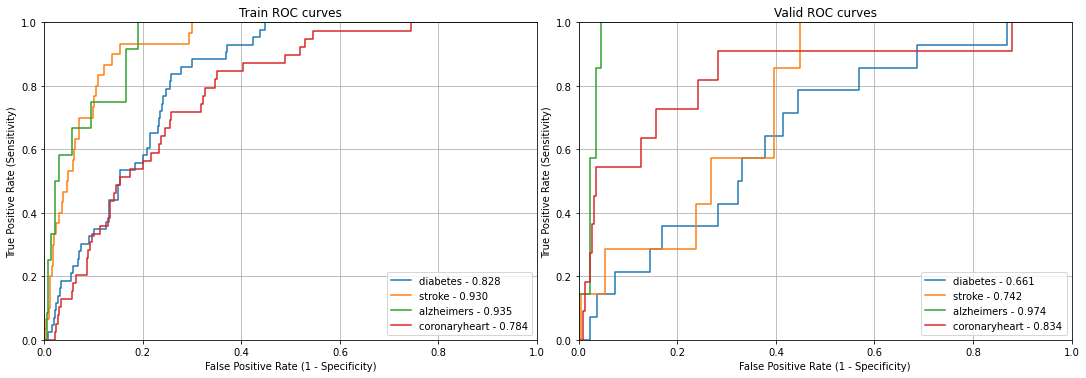

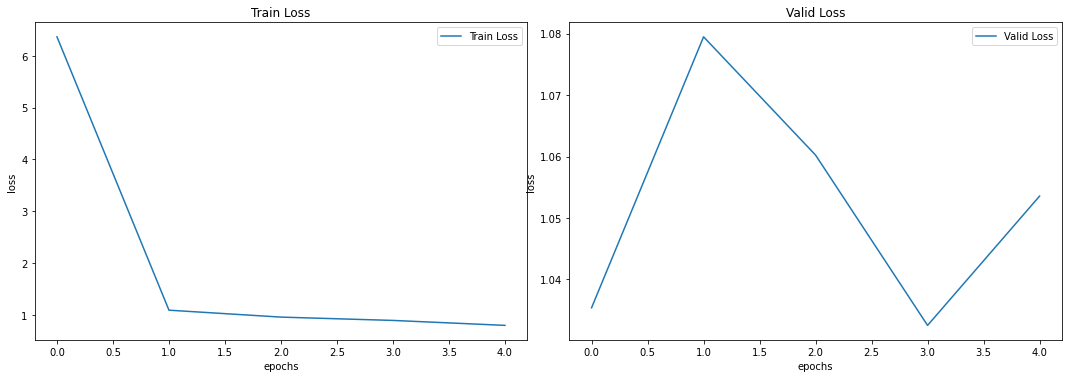

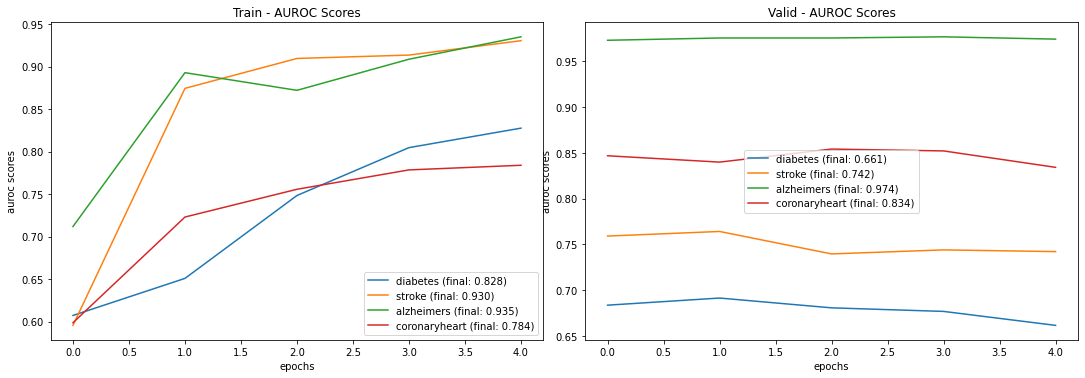

In [ ]:
plot_fit_results(h, LABELS)


Prediction Summary ...
               auroc_score  optimal_threshold     auroc_95_ci
diabetes          0.773148           0.496295  (0.694, 0.842)
stroke            0.895292           0.798374  (0.783, 0.969)
alzheimers        0.886463           0.666279  (0.797, 0.959)
coronaryheart     0.782873           0.692121  (0.612, 0.923)


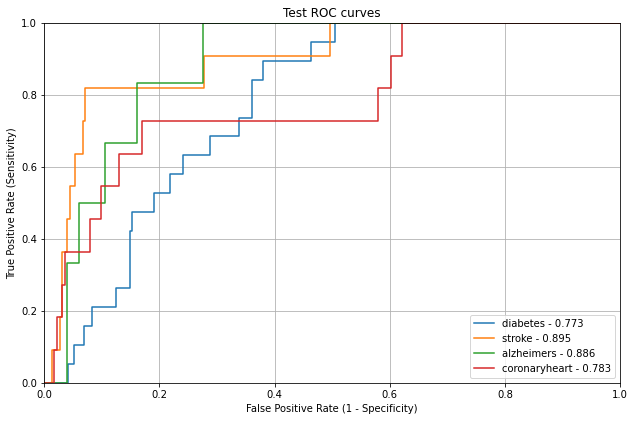

In [ ]:
h = summarize_prediction(h, LABELS)

In [ ]:
h.prediction_summary

,auroc_score,optimal_threshold,auroc_95_ci
diabetes,0.773148,0.496295,"(0.694, 0.842)"
stroke,0.895292,0.798374,"(0.783, 0.969)"
alzheimers,0.886463,0.666279,"(0.797, 0.959)"
coronaryheart,0.782873,0.692121,"(0.612, 0.923)"


## `EHR_CNN`

Based on the Deepr paper<br>
[Nguyen. et al. Deepr: A Convolutional Net for Medical Records](https://arxiv.org/abs/1607.07519)

**Sizes (+ Conv Arithmetic)**

- https://arxiv.org/pdf/1603.07285.pdf
- conv arithmetic - https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

In [ ]:
bs = 64 #batch size # of patients
wd = 85 #rec_emb_width (concat of 1 yr of records)
ht = 240 #num of years of pt data (seq_len or bptt in lstm)

**Each pt is a 20 by 85 matrix**
- 20 years on axis 0 (height)
- 85 codes on axis 1 (width)

In [ ]:
tst_pts = torch.randn(bs,ht,wd)

In [ ]:
tst_pts.shape

torch.Size([64, 240, 85])

But ...
- **Input ::** $(N, C_{in}, H_{in}, W_{in})$
- **Output::** $(N, C_{out}, H_{out}, W_{out})$

So need to reshape to insert $C_{in}$ (which is 1 in this case) after bs

In [ ]:
tst_pts = tst_pts.reshape(bs,1,ht,wd)
tst_pts.shape

torch.Size([64, 1, 240, 85])

In [ ]:
m = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(5,5), padding=2), nn.ReLU(),
    nn.Conv2d(2,4,kernel_size=(3,3), padding=1), nn.ReLU(),
    nn.Conv2d(4,8,kernel_size=(3,3), stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(8,16,kernel_size=(3,3), stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16,32,kernel_size=(3,3), stride=2, padding=1), nn.ReLU(),
    nn.AdaptiveMaxPool2d((4,4)),
    nn.Flatten()
)

In [ ]:
out = m(tst_pts)

In [ ]:
out.shape

torch.Size([64, 512])

- AdaptivePool ensures output before Flatten is bs x 16 x 5 x 5
- And thus Flatten will always flatten it to bs x 400
- **So can use 400 safely** - no matter the size of the input (which will change based on vocab dims)

In [ ]:
for name, param in m.named_parameters():
    print(name)

0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
6.weight
6.bias
8.weight
8.bias


In [ ]:
#export
def init_cnn(m, initrange, zero_bn=False):
    '''Initialize CNN as described in fast.ai'''
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Embedding, nn.EmbeddingBag)): m.weight.data.uniform_(-initrange, initrange)
    if isinstance(m, (nn.Conv2d, nn.Linear)): nn.init.kaiming_normal_(m.weight)
    if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)): nn.init.constant_(m.weight, 0. if zero_bn else 1.)
    for l in m.children(): init_cnn(l, initrange, zero_bn)

def conv_layer(in_channels, out_channels, kernel_size, stride=1, padding=1, bn=False):
    '''Create a single conv layer - as described in fast.ai'''
    layer = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=not bn)]
    if bn: layer.append(nn.BatchNorm2d(out_channels))
    layer.append(nn.ReLU(inplace=True))
    return layer

Based on perf tuning recommendation.. 
- [Disabling bias for convolutions if directly followed by a batch norm](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html#disable-bias-for-convolutions-directly-followed-by-a-batch-norm)

In [ ]:
#export
class EHR_CNN(nn.Module):
    '''Based on the model described in the Deepr paper - https://arxiv.org/abs/1607.07519'''
    def __init__(self, demograph_dims, rec_dims, demograph_wd, rec_wd, linear_layers=4, 
                 initrange=0.3, bn=False, input_drp=0.3, linear_drp=0.3, zero_bn=False):
        
        super().__init__()
        
        self.embs  = nn.ModuleList([nn.Embedding(*dim) for dim in demograph_dims])
        self.embgs = nn.ModuleList([nn.EmbeddingBag(*dim) for dim in rec_dims])
        
        self.rec_wd        = rec_wd      
        self.demograph_wd  = demograph_wd 
        self.bn            = bn
        lin_features_start = (demograph_wd + 1) + 512 #adding 1 for 'age_now', 512 = cnn output

        
        self.input_dp = InputDropout(input_drp)

        out, self.lin = create_linear_layers(lin_features_start, linear_layers, bn, linear_drp)
        self.lin_o    = nn.Linear(out, 4)     

        self.cnn = nn.Sequential(
        *conv_layer(in_channels=1, out_channels=2, kernel_size=(5,5), padding=2, bn=self.bn),
        *conv_layer(2,4,kernel_size=(3,3), padding=1, bn=self.bn),
        *conv_layer(4,8,kernel_size=3, stride=2, padding=1, bn=self.bn),
        *conv_layer(8,16,kernel_size=3, stride=2, padding=1, bn=self.bn),
        *conv_layer(16,32,kernel_size=3, stride=2, padding=1, bn=self.bn),
        nn.AdaptiveMaxPool2d((4,4)),
        nn.Flatten()
        )
        
        init_cnn(self, initrange, zero_bn)


    def get_embs(self, ptbatch_recs, ptbatch_demogs, x):
        for p in range(len(x)): #for the batch of pts
            ptbatch_recs[p] = torch.cat((self.embgs[0](x[p].obs_nums,x[p].obs_offsts), 
                                         self.embgs[1](x[p].alg_nums,x[p].alg_offsts),
                                         self.embgs[2](x[p].crpl_nums,x[p].crpl_offsts),
                                         self.embgs[3](x[p].med_nums,x[p].med_offsts),
                                         self.embgs[4](x[p].img_nums,x[p].img_offsts),
                                         self.embgs[5](x[p].proc_nums,x[p].proc_offsts),
                                         self.embgs[6](x[p].cnd_nums,x[p].cnd_offsts),
                                         self.embgs[7](x[p].imm_nums,x[p].imm_offsts)),
                                        dim=1) #for the entire age span, example all 20 yrs
            ptbatch_demogs[p] = torch.cat((self.embs[0](x[p].demographics[0]), 
                                           self.embs[1](x[p].demographics[1]),
                                           self.embs[2](x[p].demographics[2]),
                                           self.embs[3](x[p].demographics[3]),
                                           self.embs[4](x[p].demographics[4]),
                                           self.embs[5](x[p].demographics[5]),
                                           self.embs[6](x[p].demographics[6]),
                                           self.embs[7](x[p].demographics[7]),
                                           self.embs[8](x[p].demographics[8]),
                                           self.embs[9](x[p].demographics[9]),
                                           self.embs[10](x[p].demographics[10]),
                                           x[p].age_now)) 

        return ptbatch_recs, ptbatch_demogs
    
    def forward(self, x):
        
        bs     = len(x)
        height = len(x[0].obs_offsts)
        width  = self.rec_wd

        ptbatch_recs   = torch.empty(bs,height,width, device=DEVICE)
        ptbatch_demogs = torch.empty(bs,self.demograph_wd+1, device=DEVICE)
        
        ptbatch_recs, ptbatch_demogs = self.get_embs(ptbatch_recs, ptbatch_demogs, x)
        ptbatch_recs = self.input_dp(ptbatch_recs)                                    #apply input dropout
        
        res = self.cnn(ptbatch_recs.reshape(bs,1,height,width))                       #cnn output
        res   = self.lin(torch.cat((res, ptbatch_demogs), dim=1))                     #concat demographics + send thru linear lyrs
        out   = self.lin_o(res)
        
        return out

**Load Data + Inspect**

In [ ]:
ehr_1K_data = EHRData(PATH_1K, LABELS, age_start=240, age_stop=360, age_in_months=True, lazy_load_gpu=False) #entire dataset on GPU

In [ ]:
demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd = get_all_emb_dims(EhrVocabList.load(PATH_1K))

In [ ]:
train_dl, valid_dl, train_pos_wts, valid_pos_wts = ehr_1K_data.get_data()

**Inspect Model**

In [ ]:
model = EHR_CNN(demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd)

In [ ]:
model

EHR_CNN(
  (embs): ModuleList(
    (0): Embedding(33, 8)
    (1): Embedding(14, 7)
    (2): Embedding(124, 11)
    (3): Embedding(5, 5)
    (4): Embedding(7, 6)
    (5): Embedding(4, 5)
    (6): Embedding(4, 5)
    (7): Embedding(243, 14)
    (8): Embedding(208, 13)
    (9): Embedding(3, 5)
    (10): Embedding(181, 13)
  )
  (embgs): ModuleList(
    (0): EmbeddingBag(536, 17, mode=mean)
    (1): EmbeddingBag(26, 8, mode=mean)
    (2): EmbeddingBag(50, 9, mode=mean)
    (3): EmbeddingBag(226, 13, mode=mean)
    (4): EmbeddingBag(11, 6, mode=mean)
    (5): EmbeddingBag(137, 12, mode=mean)
    (6): EmbeddingBag(184, 13, mode=mean)
    (7): EmbeddingBag(20, 7, mode=mean)
  )
  (input_dp): InputDropout()
  (lin): Sequential(
    (0): Linear(in_features=605, out_features=1210, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1210, out_features=2420, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): 

In [ ]:
# for name, param in model.named_parameters():
#     print(f'{name}::\n{param}')

### Test `fit()`

In [ ]:
train_loss_fn, valid_loss_fn = get_loss_fn(train_pos_wts), get_loss_fn(valid_pos_wts)

In [ ]:
model = EHR_CNN(demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd).cuda() #.cuda() to be called before optim

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters())

In [ ]:
h = RunHistory(LABELS)

In [ ]:
%time h = fit(3, h, model, train_loss_fn, valid_loss_fn, optimizer, auroc_score, \
              train_dl, valid_dl, to_chkpt_path=MODEL_STORE, from_chkpt_path=None, verbosity=1)

epoch |     train loss |     train aurocs                  valid loss |     valid aurocs    
----------------------------------------------------------------------------------------------------
    0 |       1216.204 | [0.498 0.652 0.659 0.548]              1.402 | [0.668 0.778 0.952 0.195]
    1 |          1.689 | [0.532 0.704 0.699 0.577]              1.140 | [0.598 0.761 0.922 0.839]
    2 |          1.171 | [0.669 0.850 0.798 0.728]              1.276 | [0.640 0.774 0.971 0.839]
Checkpointed to "/home/vinod/.lemonpie/models/checkpoint.tar"
CPU times: user 6.74 s, sys: 589 ms, total: 7.33 s
Wall time: 7.57 s


In [ ]:
%time h = fit(2, h, model, train_loss_fn, valid_loss_fn, optimizer, auroc_score, \
              train_dl, valid_dl, to_chkpt_path=MODEL_STORE, from_chkpt_path=MODEL_STORE, verbosity=1)

From "/home/vinod/.lemonpie/models/checkpoint.tar", loading model ...
loading optimizer and epoch_index ...
epoch |     train loss |     train aurocs                  valid loss |     valid aurocs    
----------------------------------------------------------------------------------------------------
    3 |          1.187 | [0.706 0.843 0.901 0.594]              1.149 | [0.601 0.758 0.971 0.838]
    4 |          1.076 | [0.739 0.883 0.845 0.648]              1.099 | [0.634 0.741 0.969 0.824]
Checkpointed to "/home/vinod/.lemonpie/models/checkpoint.tar"
CPU times: user 4.81 s, sys: 765 ms, total: 5.58 s
Wall time: 5.74 s


### Test `predict()`

In [ ]:
test_dl, test_pos_wts = ehr_1K_data.get_test_data()

In [ ]:
len(test_dl), test_pos_wts

(2, tensor([11., 20., 38., 20.]))

In [ ]:
test_loss_fn = get_loss_fn(test_pos_wts)

In [ ]:
h = predict(h, model, test_loss_fn, auroc_score, test_dl, chkpt_path=MODEL_STORE)

From "/home/vinod/.lemonpie/models/checkpoint.tar", loading model ...
test loss = 0.9510343968868256
test aurocs = [0.723928 0.929383 0.922853 0.849432]


### Test plotting + results

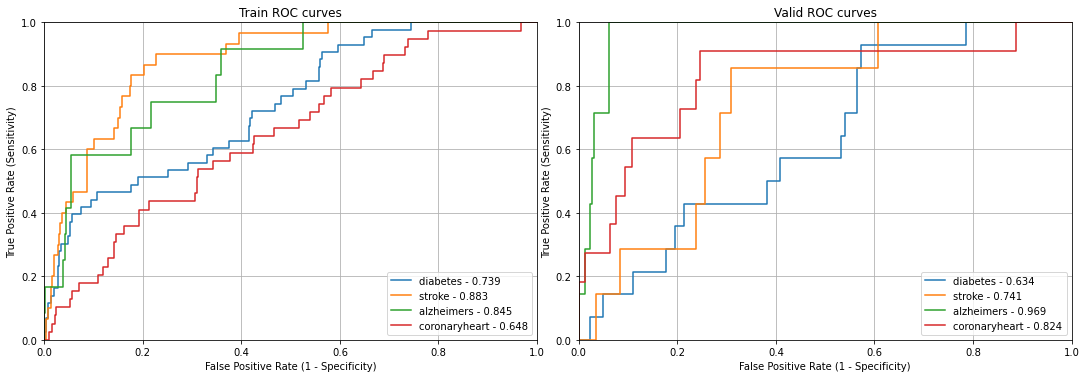

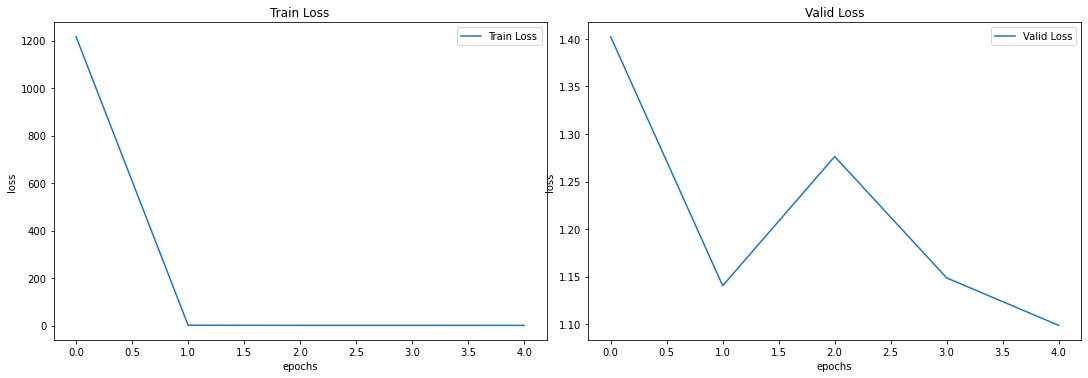

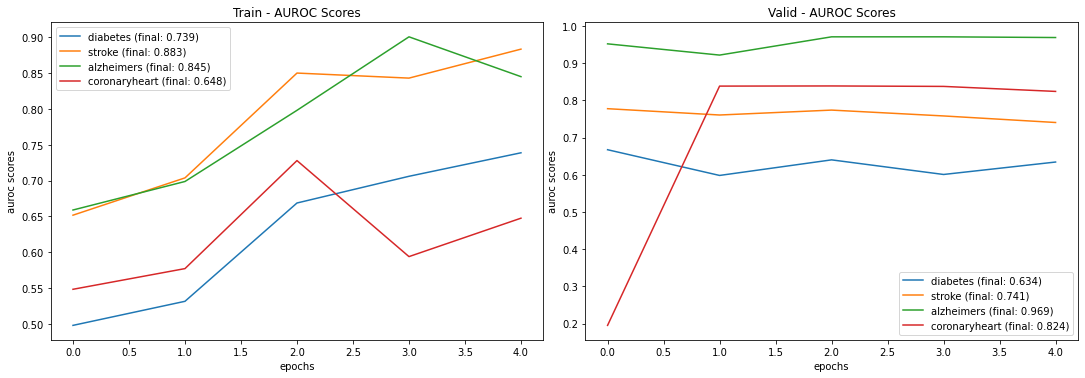

In [ ]:
plot_fit_results(h, LABELS)


Prediction Summary ...
               auroc_score  optimal_threshold     auroc_95_ci
diabetes          0.723928           0.688363  (0.615, 0.824)
stroke            0.929383           0.783293   (0.864, 0.98)
alzheimers        0.922853           0.711087  (0.866, 0.974)
coronaryheart     0.849432           0.567541  (0.728, 0.939)


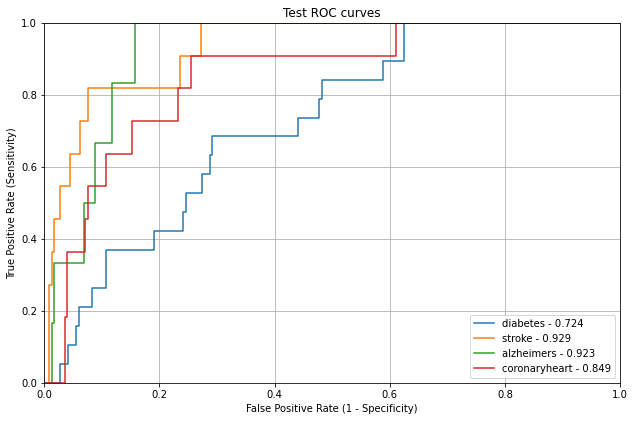

In [ ]:
h = summarize_prediction(h, LABELS)

In [ ]:
h.prediction_summary

,auroc_score,optimal_threshold,auroc_95_ci
diabetes,0.723928,0.688363,"(0.615, 0.824)"
stroke,0.929383,0.783293,"(0.864, 0.98)"
alzheimers,0.922853,0.711087,"(0.866, 0.974)"
coronaryheart,0.849432,0.567541,"(0.728, 0.939)"


## Export -

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_basics.ipynb.
Converted 01_preprocessing_clean.ipynb.
Converted 02_preprocessing_vocab.ipynb.
Converted 03_preprocessing_transform.ipynb.
Converted 04_data.ipynb.
Converted 05_metrics.ipynb.
Converted 06_learn.ipynb.
Converted 07_models.ipynb.
Converted 08_experiment.ipynb.
Converted 99_quick_walkthru.ipynb.
Converted 99_running_exps.ipynb.
Converted index.ipynb.
